# Training a transfer learning model

This tutorial illustrates how to use a transfer learning approach to train a model on the GC mEPSP dataset. The miniML base model, trained on GC mEPSCs, is used as a starting point. We freeze the convolutional layers of the base model and train the remaining layers on the GC mEPSP dataset. This transfer learning approach greatly reduces the training time and the required size of the training dataset.

## Preparation

We begin by downloading the example files for training a model for mEPSP detection from Kaggle. 

In [ ]:
import kaggle

kaggle.api.dataset_download_files('philipponeill/miniml-training-data', path='../_data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/philipponeill/miniml-training-data


In [2]:
import tensorflow as tf
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from tensorflow.keras.layers import (Input, BatchNormalization, AveragePooling1D, Conv1D, 
                                     Bidirectional, LSTM, Dense, Dropout, LeakyReLU)
from tensorflow.keras.optimizers.legacy import Adam
from scipy.signal import resample
import h5py
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings

print('Using TF version', tf.__version__)
print('GPUs available:', len(tf.config.list_physical_devices('GPU')))

Using TF version 2.15.0
GPUs available: 1


## Set training parameters

In [5]:
settings = {
    'training_size': 0.8,
    'testing_size': None,
    'learn_rate': 2e-8,
    'epsilon': 1e-8,
    'patience': 15,
    'epochs': 100,
    'batch_size': 32,
    'dropout': 0.5,
    'training_data': '../_data/GC_mEPSP_training_data.h5',
    'base_model': '../_data/GC_lstm_model.h5'
}

## Prepare training data

We begin by loading the training dataset. The data is stored in a HDF5 file.

The data is loaded into the *x* and *y* variables. The data is resampled to 600 datapoints and the events are inverted. Because the base model was trained to detect downward deflections, inverting the data helps when training on data having a different direction. When using the trained model, remember to set the event_direction parameter to 'positive' when generating the EventDetection object. 

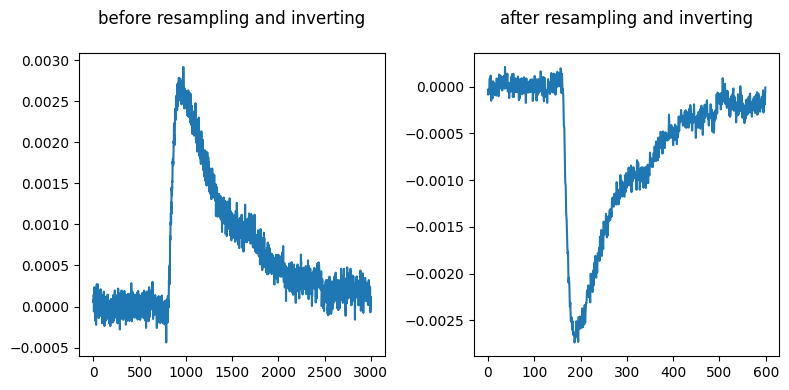

In [6]:
with h5py.File(f'{settings["training_data"]}', 'r') as f:
    x = f['events'][:]
    y = f['scores'][:]

fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(x[1])
axs[0].set_title('before resampling and inverting\n')

# resample and invert the data
x = resample(x, 600, axis=1)
x *= -1

axs[1].plot(x[1])
axs[1].set_title('after resampling and inverting\n')
plt.tight_layout()
plt.show()

Next, we proceed as for full model training by min-max scaling and splitting the data into training and testing sets.

In [7]:
scaled_data = minmax_scale(x, feature_range=(0,1), axis=1)
scaled_data = np.expand_dims(scaled_data, axis=2)
merged_y = np.expand_dims(y, axis=1)

print(f'loaded events with shape {scaled_data.shape}')
print(f'loaded scores with shape {merged_y.shape}') 
print(f'ratio of pos/neg scores: {merged_y.sum()/(merged_y.shape[0]-merged_y.sum()):.2f}')

if merged_y.sum()/(merged_y.shape[0]-merged_y.sum()) > 1.05:
    warnings.warn("unbalanced dataset: ratio of positive and negative scores >1.05")
elif merged_y.sum()/(merged_y.shape[0]-merged_y.sum()) < 0.95:
    warnings.warn("unbalanced dataset: ratio of positive and negative scores < 0.95")

x_train, x_test, y_train, y_test = train_test_split(scaled_data, merged_y, train_size=settings['training_size'], random_state=1234)

loaded events with shape (1000, 600, 1)
loaded scores with shape (1000, 1)
ratio of pos/neg scores: 1.00


### Prepare the model

In [8]:
def build_model(x_train, dropout):
    dropout_rate = dropout

    model = tf.keras.models.Sequential()
    model.add(Input(shape=(x_train.shape[1:])))
              
    model.add(Conv1D(filters=32, kernel_size=9, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=3, strides=3))
    
    model.add(Conv1D(filters=48, kernel_size=7, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Conv1D(filters=64, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2, strides=2))
    
    model.add(Conv1D(filters=80, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Bidirectional(LSTM(96, dropout=dropout_rate), 
                            merge_mode='sum'))
    model.add(Dense(128, activation=LeakyReLU()))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

Save model weights from the pre-trained model and freeze the convolutional layers to prevent them from being trained.

In [ ]:
# open old model and save weights
old_model = tf.keras.models.load_model(settings['base_model'], compile=True)
old_model.save_weights('../_data/gc_weights')

# re-create model with different input shape
new_model = build_model(x_train, settings['dropout'])
new_model.summary()

# Load old model weights into new model
new_model.load_weights('../_data/gc_weights')

2025-01-08 10:20:38.436878: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-01-08 10:20:38.436922: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-08 10:20:38.436933: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-08 10:20:38.436973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 10:20:38.436995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 600, 32)           320       
                                                                 
 batch_normalization (Batch  (None, 600, 32)           128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 600, 32)           0         
                                                                 
 average_pooling1d (Average  (None, 200, 32)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 48)           10800     
                                                                 
 batch_normalization_1 (Bat  (None, 200, 48)           1

In [10]:
# Freeze / unfreeze layers that should / should not be trained
for ind, layer in enumerate(new_model.layers):
    if layer.name == 'BatchNormalization':
        new_model.layers[ind].trainable = False
    else:
        if ind < len(new_model.layers) - 4:
            new_model.layers[ind].trainable = False
        else:
            new_model.layers[ind].trainable = True
              
new_model.compile(optimizer=Adam(learning_rate=settings['learn_rate'], epsilon=settings['epsilon'], amsgrad=True),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['Accuracy'])

new_model.summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 600, 32)           320       N          
                                                                            
 batch_normalization (Batch  (None, 600, 32)           128       N          
 Normalization)                                                             
                                                                            
 leaky_re_lu (LeakyReLU)     (None, 600, 32)           0         N          
                                                                            
 average_pooling1d (Average  (None, 200, 32)           0         N          
 Pooling1D)                                                                 
                                                                            
 conv1d_1 (Conv1D)           (None, 200, 48)           1

## Training

Now we can train our model. Only the previously selected layers are trained.

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=settings['patience'],
    restore_best_weights=True)

start = time.time()

history = new_model.fit(x_train,y_train,
            verbose=2,
            epochs=settings['epochs'],
            batch_size=settings['batch_size'],
            validation_data=(x_test,y_test),
            shuffle=True,
            callbacks=[early_stopping_callback])

print('')
print('----')
print(f'train shape: {x_train.shape}')
print(f'score on val: {new_model.evaluate(x_test, y_test, verbose=0)[1]}')
print(f'score on train: {new_model.evaluate(x_train, y_train, verbose=0)[1]}')
print('----')
print(f'training time (s): {time.time()-start:.4f}')

Epoch 1/100
25/25 - 1s - loss: 0.1036 - Accuracy: 0.9538 - val_loss: 0.0982 - val_Accuracy: 0.9600 - 688ms/epoch - 28ms/step
Epoch 2/100
25/25 - 1s - loss: 0.0937 - Accuracy: 0.9613 - val_loss: 0.0987 - val_Accuracy: 0.9600 - 608ms/epoch - 24ms/step
Epoch 3/100
25/25 - 1s - loss: 0.0953 - Accuracy: 0.9625 - val_loss: 0.1018 - val_Accuracy: 0.9600 - 585ms/epoch - 23ms/step
Epoch 4/100
25/25 - 1s - loss: 0.1069 - Accuracy: 0.9575 - val_loss: 0.1042 - val_Accuracy: 0.9550 - 716ms/epoch - 29ms/step
Epoch 5/100
25/25 - 1s - loss: 0.0986 - Accuracy: 0.9588 - val_loss: 0.1017 - val_Accuracy: 0.9600 - 667ms/epoch - 27ms/step
Epoch 6/100
25/25 - 1s - loss: 0.1010 - Accuracy: 0.9575 - val_loss: 0.1081 - val_Accuracy: 0.9550 - 589ms/epoch - 24ms/step
Epoch 7/100
25/25 - 1s - loss: 0.0941 - Accuracy: 0.9588 - val_loss: 0.1020 - val_Accuracy: 0.9600 - 588ms/epoch - 24ms/step
Epoch 8/100
25/25 - 1s - loss: 0.0912 - Accuracy: 0.9625 - val_loss: 0.1047 - val_Accuracy: 0.9550 - 640ms/epoch - 26ms/step


## Plot training and evaluate the model

We can plot the training and validation accuracy and loss to visualize the training progress.

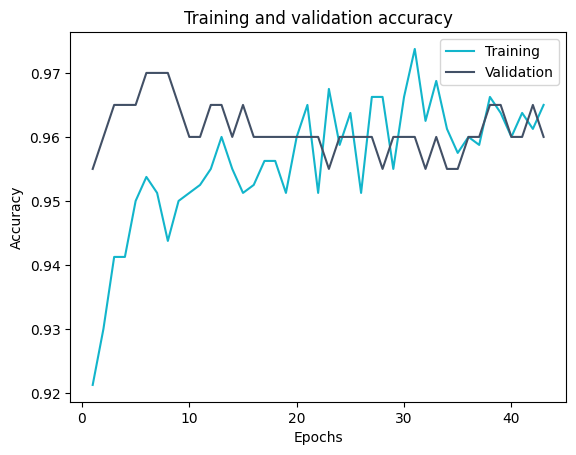

Best epoch: 6 (accuracy=0.9700)


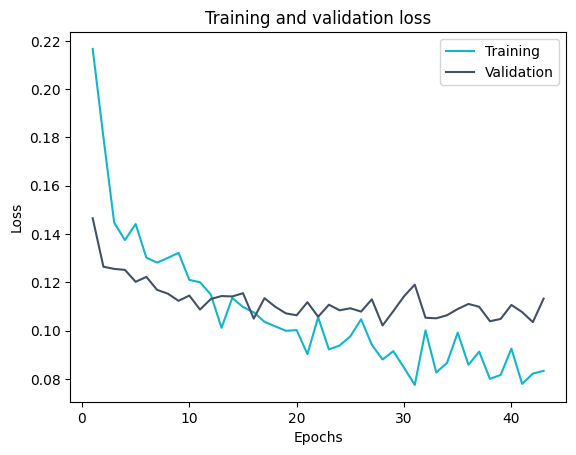

In [46]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '#12B5CB', label='Training')
plt.plot(epochs, val_acc, '#425066', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

best_epoch = val_acc.index(max(val_acc)) + 1
print(f'Best epoch: {best_epoch} (accuracy={max(val_acc):.4f})')
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, '#12B5CB', label='Training')
plt.plot(epochs, val_loss, '#425066', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can plot the ROC curve and the confusion matrix to further evaluate our trained model.

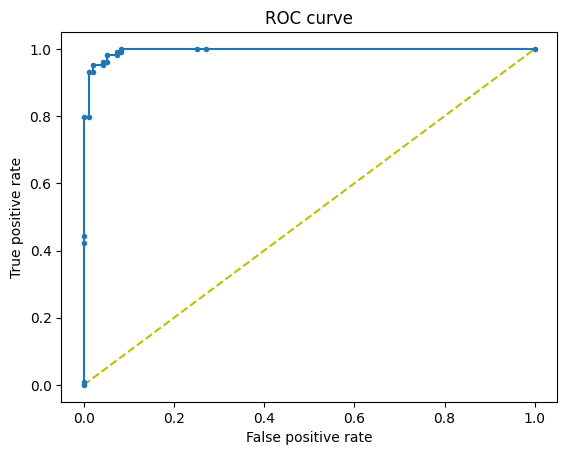

Area under curve, AUC =  0.9952924679487181
Optimal threshold value is: 0.9391768


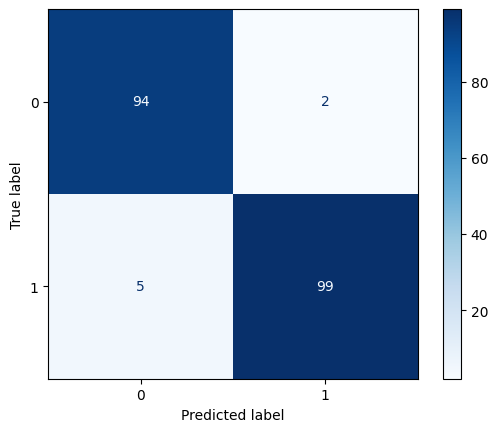

In [47]:
# ROC curve
y_preds = new_model.predict(x_test, verbose=0).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

print('Area under curve, AUC = ', auc(fpr, tpr))
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print('Optimal threshold value is:', optimal_threshold)

y_pred2 = (new_model.predict(x_test, verbose=0) >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

## Save trained model and training settings

Finally, we save the trained model to an .h5 file and the training settings to a text file.

In [48]:
new_model.save('../results/lstm_transfer.h5')

with open('../results/tl_training_settings.txt', 'w') as text_file:
    text_file.write('\n'.join(f'{i}: {settings[i]}' for i in settings))

/opt/miniconda3/envs/miniml/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
